In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
from scipy.stats import entropy
from scipy.stats import mode

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import accuracy_score, classification_report, f1_score
import statistics as st

from google.colab import files

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directory = "/content/drive/MyDrive/PAMAP2_Dataset/Protocol" #'PAMAP2_Dataset\Protocol'
subj_dfs = pd.DataFrame()

for subj_num in range(101, 110):
    file_path = os.path.join(directory, f'subject{subj_num}.dat')
    subj = np.loadtxt(file_path)

    test_dict = {'user': np.repeat([subj_num % 100], len(subj)),
                'acc_x': subj[:, 4], 'acc_y': subj[:, 5], 'acc_z': subj[:, 6],
                'activity': subj[:, 1]}
    subj_df = pd.DataFrame(test_dict)
    subj_dfs = pd.concat([subj_dfs, subj_df], ignore_index=True)

In [ ]:
subj_dfs.sample(100)

,user,acc_x,acc_y,acc_z,activity
1409346,5,0.915323,9.82705,-0.633634,0.0
2660575,8,-9.580550,-5.19926,6.957310,0.0
565880,2,-9.770680,7.81045,2.061170,0.0
544414,2,-7.832430,2.21154,1.377830,0.0
1705261,5,-3.277630,4.05806,8.175120,0.0
...,...,...,...,...,...
1774465,5,3.181830,1.48476,-6.537090,24.0
32037,1,0.339560,9.39305,-2.988520,2.0
581572,2,8.357780,2.88605,1.925970,0.0
1120451,4,-2.264020,5.18467,7.763140,2.0


In [ ]:
unique_users = [1, 2, 3, 4, 5, 6, 7, 8, 9] # hardcoded the num of datasets to do train/test split
train_users, test_users = train_test_split(unique_users, test_size=0.25, random_state=1)

train_df = subj_dfs[subj_dfs['user'].isin(train_users)]
test_df = subj_dfs[subj_dfs['user'].isin(test_users)]

In [ ]:
features_list = ["mean", "median", "variance", "max", "min", "average magnitude", "max magnitude", "min magnitude"]

In [ ]:
def statistical_features(segment):
    features = {}

    x = segment['acc_x'].values
    y = segment['acc_y'].values
    z = segment['acc_z'].values

    mag_x = np.sqrt(np.sum(x**2, axis = 0))
    mag_y = np.sqrt(np.sum(y**2, axis = 0))
    mag_z = np.sqrt(np.sum(z**2, axis = 0))

    # features
    # removed st.mode(x), y, z
    x_feat = [np.mean(x), np.median(x), np.var(x), np.max(x), np.min(x), np.mean(mag_x), np.max(mag_x), np.min(mag_x)]
    y_feat = [np.mean(y), np.median(y), np.var(y), np.max(y), np.min(y), np.mean(mag_y), np.max(mag_y), np.min(mag_y)]
    z_feat = [np.mean(z), np.median(z), np.var(z), np.max(z), np.min(z), np.mean(mag_z), np.max(mag_z), np.min(mag_z)]

    feat = np.array([x_feat, y_feat, z_feat]).flatten()
    #print(feat.shape[0])

    return feat

In [ ]:
def sliding_window(df, window_size, step_size):

    features = []
    majority_votes = []

    num_cols = 3 #len(df.columns) # should be 3

    #window = window_size * 3  # start with 50x3, window_size = 50
    print(len(df))
    print(step_size)

    count = 0
    for start in tqdm(range(0, len(df), step_size)):
        # if start % 15000 == 0:
        #   print(start)
        end = start + window_size # non overlapping
        segment = df[start:end]

        feature = statistical_features(segment[['acc_x', 'acc_y', 'acc_z']])
        features.append(feature)

        majority_votes.append(st.mode(segment['activity'].values))
        count += 1

    print('count: {}'.format(count))
    print('features shape: '.format(np.array(features).shape))
    print('majority votes shape: '.format(np.array(majority_votes).shape))
    return features, majority_votes

In [ ]:
"""
Overlapping version

def sliding_window(df, window_size, step_size, overlap_ratio):
    features = []
    majority_votes = []

    num_cols = 3  # len(df.columns) # should be 3

    count = 0
    for start in tqdm(range(0, len(df) - window_size + 1, int(step_size * (1 - overlap_ratio)))):
        end = start + window_size
        segment = df[start:end]

        feature = statistical_features(segment[['acc_x', 'acc_y', 'acc_z']])
        features.append(feature)

        majority_votes.append(st.mode(segment['activity'].values))
        count += 1

    print('count: {}'.format(count))
    print('features shape: '.format(np.array(features).shape))
    print('majority votes shape: '.format(np.array(majority_votes).shape))
    return features, majority_votes
"""

In [ ]:
train_df = train_df.dropna()
test_df = test_df.dropna()

In [ ]:
train_windows, train_labels = sliding_window(train_df, 100, 100)
test_windows, test_labels = sliding_window(test_df, 100, 100)

2286514
100


  0%|          | 0/22866 [00:00<?, ?it/s]

count: 22866
features shape: 
majority votes shape: 
572878
100


  0%|          | 0/5729 [00:00<?, ?it/s]

count: 5729
features shape: 
majority votes shape: 


In [ ]:
test_windows_df = pd.DataFrame(test_windows)
test_windows_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.225589,-0.204907,0.011559,-0.004464,-0.588416,2.498996,2.498996,2.498996,9.716556,9.716520,...,97.181218,97.181218,-1.303097,-1.303965,0.026813,-0.958518,-1.92431,13.133450,13.133450,13.133450
1,0.170107,0.042744,0.239282,1.387250,-0.678023,5.178975,5.178975,5.178975,9.416598,9.455745,...,94.650929,94.650929,0.497739,0.453118,3.586806,3.777980,-4.37858,19.582009,19.582009,19.582009
2,-5.207339,-4.023570,10.333894,-0.888605,-10.801100,61.196629,61.196629,61.196629,7.211629,7.536115,...,75.657256,75.657256,-1.179526,-1.586530,6.838018,3.122250,-4.89904,28.686756,28.686756,28.686756
3,-8.806739,-8.890100,0.207880,-7.946700,-9.770040,88.185337,88.185337,88.185337,3.418150,3.443285,...,34.583413,34.583413,2.726237,2.776690,0.080423,3.285550,2.10167,27.409469,27.409469,27.409469
4,-8.947358,-8.958335,0.011188,-8.695800,-9.188950,89.479832,89.479832,89.479832,3.198406,3.215540,...,32.017185,32.017185,2.343462,2.357810,0.015587,2.629120,2.09292,23.467854,23.467854,23.467854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5724,-5.597601,-7.548020,48.009271,4.984510,-26.538100,89.074357,89.074357,89.074357,5.260241,4.141055,...,70.998992,70.998992,3.546308,1.485450,39.018286,44.463100,-1.66238,71.829371,71.829371,71.829371
5725,-7.456118,-8.006705,7.890592,-0.447872,-11.218500,79.677028,79.677028,79.677028,5.891400,5.982495,...,62.522288,62.522288,-1.142558,-1.576185,8.011746,4.349200,-5.72904,30.524064,30.524064,30.524064
5726,-1.432044,-0.265138,10.529354,2.708340,-7.495250,35.468442,35.468442,35.468442,8.522536,9.085585,...,89.410792,89.410792,1.023662,-0.703690,11.259222,7.747490,-3.75075,35.081484,35.081484,35.081484
5727,-0.626237,1.027120,12.488291,5.021160,-6.456090,35.889363,35.889363,35.889363,-0.746133,-1.113715,...,17.585034,17.585034,7.546351,8.166360,2.868856,9.695320,3.60573,77.340977,77.340977,77.340977


In [ ]:
train_labels_df = pd.DataFrame(train_labels)
train_labels_df.value_counts()

0.0     7663
17.0    1809
4.0     1713
7.0     1575
1.0     1447
2.0     1441
3.0     1437
6.0     1419
16.0    1335
5.0      931
12.0     890
13.0     782
24.0     424
dtype: int64

In [ ]:
train_windows_df = pd.DataFrame(train_windows)
train_windows_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,2.338374,2.333630,0.011505,2.59335,2.07473,23.408329,23.408329,23.408329,8.884311,8.901885,...,88.872094,88.872094,3.412408,3.412650,0.026330,3.77532,2.933980,34.162643,34.162643,34.162643
1,2.757696,2.717550,0.185404,3.70332,1.77110,27.911096,27.911096,27.911096,8.935353,9.125500,...,89.553605,89.553605,2.956669,3.103805,0.616912,4.24332,0.828399,30.592161,30.592161,30.592161
2,2.752680,2.759350,0.023851,3.09370,2.38855,27.570084,27.570084,27.570084,8.691075,8.747675,...,86.980210,86.980210,3.635951,3.594340,0.067714,4.32425,3.204850,36.452503,36.452503,36.452503
3,2.547358,2.622815,0.100167,3.12721,1.61267,25.669442,25.669442,25.669442,8.868735,8.787475,...,88.824490,88.824490,3.593018,3.587675,0.150803,4.55270,2.545590,36.139431,36.139431,36.139431
4,2.890119,2.446160,0.914049,5.21919,1.91794,30.441475,30.441475,30.441475,8.584101,8.604255,...,86.099705,86.099705,3.547539,3.794310,0.416380,4.35728,1.630360,36.057475,36.057475,36.057475


Creating test and training DFs with 5 least significant features dropped

In [ ]:
# creating df with 5 least significant features dropped
cols_dropped = [7, 8, 9, 21, 22, 23]
train_windows_df_droppedfive = train_windows_df.drop(
    train_windows_df.columns[cols_dropped], axis = 1)
train_windows_df_droppedfive.head()

,0,1,2,3,4,5,6,10,11,12,13,14,15,16,17,18,19,20
0,2.338374,2.333630,0.011505,2.59335,2.07473,23.408329,23.408329,0.051511,9.31986,8.11091,88.872094,88.872094,88.872094,3.412408,3.412650,0.026330,3.77532,2.933980
1,2.757696,2.717550,0.185404,3.70332,1.77110,27.911096,27.911096,0.357942,9.90320,7.05235,89.553605,89.553605,89.553605,2.956669,3.103805,0.616912,4.24332,0.828399
2,2.752680,2.759350,0.023851,3.09370,2.38855,27.570084,27.570084,0.120781,9.35263,7.42372,86.980210,86.980210,86.980210,3.635951,3.594340,0.067714,4.32425,3.204850
3,2.547358,2.622815,0.100167,3.12721,1.61267,25.669442,25.669442,0.243434,10.23010,8.00247,88.824490,88.824490,88.824490,3.593018,3.587675,0.150803,4.55270,2.545590
4,2.890119,2.446160,0.914049,5.21919,1.91794,30.441475,30.441475,0.444802,10.72580,7.21471,86.099705,86.099705,86.099705,3.547539,3.794310,0.416380,4.35728,1.630360


In [ ]:
cols_dropped = [7, 8, 9, 21, 22, 23]
test_windows_df_droppedfive = test_windows_df.drop(
    test_windows_df.columns[cols_dropped], axis = 1)
test_windows_df_droppedfive.head()

,0,1,2,3,4,5,6,10,11,12,13,14,15,16,17,18,19,20
0,-0.225589,-0.204907,0.011559,-0.004464,-0.588416,2.498996,2.498996,0.030432,10.28380,9.25909,97.181218,97.181218,97.181218,-1.303097,-1.303965,0.026813,-0.958518,-1.92431
1,0.170107,0.042744,0.239282,1.387250,-0.678023,5.178975,5.178975,0.915662,11.65150,7.03182,94.650929,94.650929,94.650929,0.497739,0.453118,3.586806,3.777980,-4.37858
2,-5.207339,-4.023570,10.333894,-0.888605,-10.801100,61.196629,61.196629,5.232616,10.26490,1.63528,75.657256,75.657256,75.657256,-1.179526,-1.586530,6.838018,3.122250,-4.89904
3,-8.806739,-8.890100,0.207880,-7.946700,-9.770040,88.185337,88.185337,0.276378,4.65854,2.56973,34.583413,34.583413,34.583413,2.726237,2.776690,0.080423,3.285550,2.10167
4,-8.947358,-8.958335,0.011188,-8.695800,-9.188950,89.479832,89.479832,0.021203,3.52025,2.79790,32.017185,32.017185,32.017185,2.343462,2.357810,0.015587,2.629120,2.09292


In [ ]:
test_labels_df = pd.DataFrame(test_labels)
test_labels_df.value_counts()

0.0     1613
4.0      611
17.0     574
1.0      478
3.0      463
16.0     419
2.0      409
7.0      287
12.0     279
13.0     271
6.0      226
24.0      64
5.0       35
dtype: int64

In [ ]:
label_encoder = LabelEncoder().fit(train_labels)
old_labels = np.copy(train_labels)
train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)

Text(0.5, 1.0, 'after label encoding')

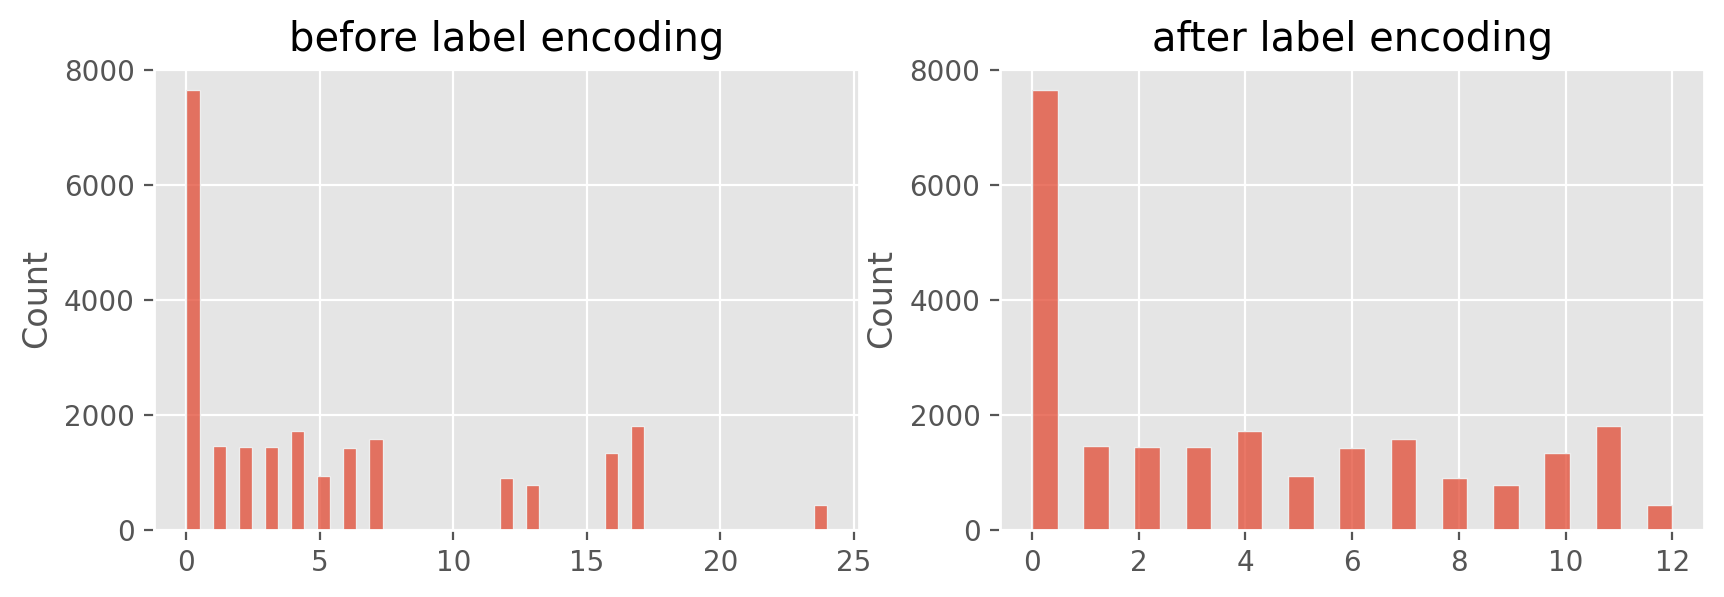

In [ ]:
plt.figure(dpi=200, figsize=(10, 3))
plt.style.use('ggplot')

plt.subplot(1, 2, 1)
sns.histplot(old_labels)
plt.title('before label encoding')

plt.subplot(1, 2, 2)
sns.histplot(train_labels) # was previously "new_labels"
plt.title('after label encoding')

# Classification

Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(train_windows, train_labels)
rf_test_predictions = rf.predict(test_windows)

accuracy = accuracy_score(test_labels, rf_test_predictions)
f1 = f1_score(test_labels, rf_test_predictions, average='macro')
print("accuracy: ", accuracy)
print("F1 score: ", f1)

accuracy:  0.4538313841857218
F1 score:  0.4016539851612762


In [ ]:
# RF for dropped 5 features

rf_dropped = RandomForestClassifier(n_estimators = 1000)
rf_dropped.fit(train_windows_df_droppedfive, train_labels)
rf_dropped_test_predictions = rf_dropped.predict(test_windows_df_droppedfive)

accuracy_dropped = accuracy_score(test_labels, rf_dropped_test_predictions)
f1_dropped = f1_score(test_labels, rf_dropped_test_predictions, average='macro')

print("accuracy: ", accuracy_dropped)
print("F1 score: ", f1_dropped)

accuracy:  0.4564496421714086
F1 score:  0.41802136334873663


In [ ]:
importances = rf.feature_importances_

final_features_list = []
dimensions = ["x", "y", "z"]

for dim in dimensions:
  for feature in features_list:
    f = f"{dim}_{feature}"
    final_features_list.append(f)

sorted_idx = np.argsort(importances)[::-1]

sorted_feature_names = [final_features_list[i] for i in sorted_idx]
sorted_importances = importances[sorted_idx]

for feature, importance in zip(sorted_feature_names, sorted_importances):
    print(f"{feature}: {importance}")

x_min: 0.0642778516745877
x_variance: 0.05588624529483733
y_variance: 0.0555627122079542
z_max: 0.04899224247293326
x_mean: 0.04731428877366311
y_max: 0.04641881806305384
z_mean: 0.0463320784139808
x_median: 0.04406393501637793
z_min: 0.04329986649551478
y_average magnitude: 0.04328555140308906
x_max: 0.04326749517038991
z_median: 0.04186168573358856
y_min magnitude: 0.041776195861620846
y_max magnitude: 0.04132500768521592
z_variance: 0.03895408557377409
x_max magnitude: 0.0357474321760759
x_average magnitude: 0.035079106539049144
x_min magnitude: 0.03471233112452506
y_min: 0.03459371843727353
z_max magnitude: 0.03166042487535524
y_mean: 0.03159281175641854
z_average magnitude: 0.031448354595626796
z_min magnitude: 0.03131634627345908
y_median: 0.031231414381635406


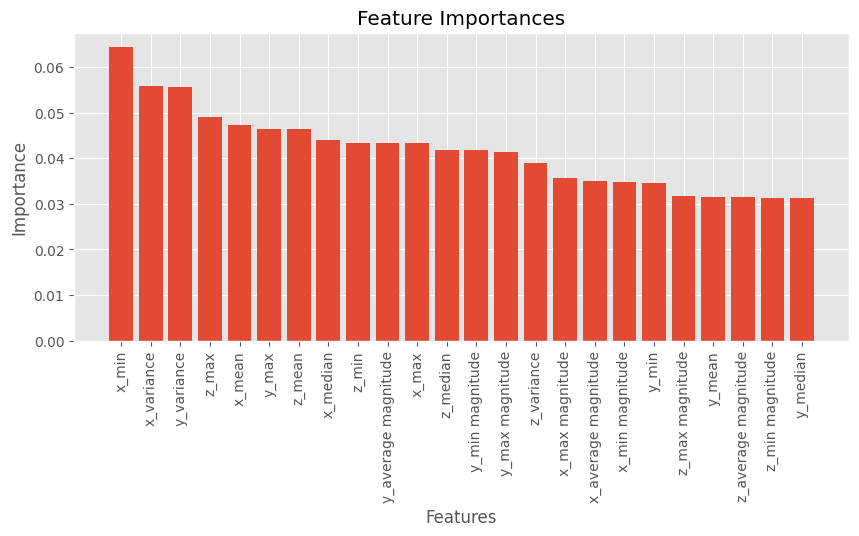

In [ ]:
plt.figure(figsize=(10, 4))
plt.bar(sorted_feature_names, sorted_importances)
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

K Nearest Neighbors

In [ ]:
# KNN 5 neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_windows, train_labels)
knn_test_predictions = knn.predict(test_windows)

accuracy = accuracy_score(test_labels, knn_test_predictions)
f1 = f1_score(test_labels, knn_test_predictions, average='macro')
print("accuracy: ", accuracy)
print("F1 score: ", f1)

accuracy:  0.40443358352242975
F1 score:  0.359154605334548


In [ ]:
# KNN 10 neighbors
knn10 = KNeighborsClassifier(n_neighbors=10)
knn10.fit(train_windows, train_labels)
knn10_test_predictions = knn10.predict(test_windows)

accuracy = accuracy_score(test_labels, knn10_test_predictions)
f1 = f1_score(test_labels, knn10_test_predictions, average='macro')
print("accuracy: ", accuracy)
print("F1 score: ", f1)

accuracy:  0.4136847617385233
F1 score:  0.36166257151717696


SVM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(train_windows)
train_windows_svm = scaling.transform(train_windows)
test_windows_svm = scaling.transform(test_windows)

In [ ]:
svm = SVC()
svm.fit(train_windows, train_labels)
svm_test_predictions = svm.predict(test_windows)

accuracy = accuracy_score(test_labels, svm_test_predictions)
f1 = f1_score(test_labels, svm_test_predictions, average='macro')
print("accuracy: ", accuracy)
print("F1 score: ", f1)

accuracy:  0.49432710769767846
F1 score:  0.380432954801592
